In [152]:
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

from sympy.physics.hydrogen import E_nl, R_nl
from sympy.plotting import plot, plot3d
from sympy import *

import scipy.special as ss
import numpy as np
import math
import copy

In [153]:
#Package for plotting Cube files
### import numpy as np
#from math import ceil, floor, sqrt
 
class Cube:
    def __init__(self, fname):
        f = open(fname, 'r')
        for i in range(2): 
            f.readline()
        tkns = f.readline().split() # number of atoms included in the file followed by the
        #position of the origin of the volumetric data
        self.natoms = int(float(tkns[0]))
        self.origin = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    # The next three lines give the number of voxels along each axis (x, y, z) followed by the axis vector.
        tkns = f.readline().split() #
        self.NX = int(tkns[0])
        self.X = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
        tkns = f.readline().split() #
        self.NY = int(tkns[0])
        self.Y = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
        tkns = f.readline().split() #
        self.NZ = int(tkns[0])
        self.Z = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    # For cube cells with axes perpendicular to each other
        self.dx = self.X[0]
        self.x_lim = self.dx*self.NX
        self.dy = self.Y[1]
        self.y_lim = self.dy*self.NY
        self.dz = self.Z[2]
        self.z_lim = self.dz*self.NZ
        self.voxel = self.dx*self.dy*self.dz
    # The last section in the header is one line for each atom consisting of 
    #5 numbers, the first is the atom number, second (?), the last three are the x,y,z coordinates of the atom center. 
        self.atoms = []
        self.cd_z={}
        self.cd_znorm={}
        for i in range(self.natoms):
            tkns = f.readline().split()
            x, y, z = float(tkns[2])%self.x_lim, float(tkns[3])%self.y_lim, float(tkns[4])%self.z_lim
            self.atoms.append([int(float(tkns[0])), x, y, z])
            chg = abs(int(float(tkns[0])) - 2)
            
            #Bin size according to voxel
            z_coord_vox=round(float(tkns[4])/self.dz, 0)*self.dz
            if z_coord_vox in self.cd_znorm.keys():
                self.cd_znorm[z_coord_vox]+=chg/self.voxel
            else:
                self.cd_znorm[z_coord_vox]=chg/self.voxel
            #Fill with zeros not written voxels
            z_axis=np.arange(0, self.z_lim, self.dz)
            for point in z_axis:
                if point not in self.cd_znorm.keys():
                    self.cd_znorm[point]=0
            #Just coordinates and charges
            z_coord=float(tkns[4])
            if float(tkns[4]) in self.cd_z.keys():
                self.cd_z[float(tkns[4])]+=chg/self.voxel
            else:
                self.cd_z[float(tkns[4])]=chg/self.voxel

        self.atoms = np.array(self.atoms)
    # Volumetric data
        self.data = np.zeros((self.NX,self.NY,self.NZ))
        i=0
        for s in f:
            for v in s.split():
                self.data[i/(self.NY*self.NZ), (i/self.NZ)%self.NY, i%self.NZ] = float(v)
                i+=1
        if i != self.NX*self.NY*self.NZ:
            raise NameError, "FSCK!"
 

    def mask_sphere(self, R, Cx,Cy,Cz):
# produce spheric volume mask with radius R and center @ [Cx,Cy,Cz]
# can be used for integration over spherical part of the volume
        m=0*self.data
        for ix in xrange( int(ceil((Cx-R)/self.X[0])), int(floor((Cx+R)/self.X[0])) ):
            ryz=sqrt(R**2-(ix*self.X[0]-Cx)**2)
            for iy in xrange( int(ceil((Cy-ryz)/self.Y[1])), int(floor((Cy+ryz)/self.Y[1])) ):
                rz=sqrt(ryz**2 - (iy*self.Y[1]-Cy)**2)
                for iz in xrange( int(ceil((Cz-rz)/self.Z[2])), int(floor((Cz+rz)/self.Z[2])) ):
                    m[ix,iy,iz]=1
        return m
    
    def _gen_grid(self):
        """Return meshgrid with x, y, z"""
        return np.mgrid[0:self.x_lim:self.dx, 0:self.y_lim:self.dy, 0:self.z_lim:self.dz]
    
    def add_atom_charges(self):
        """Add atom charges to data. Assume that we have only 1st, 2nd row atoms.
        Time consuming."""
        # we had electrons, so first of all we need to change charge
        self.data = -self.data
        for chg, x_atom, y_atom, z_atom in self.atoms:
            # remove core electrons from 2nd row, but ignore H
            chg = abs(chg - 2) 
            # find atoms closest grid points
            x_idx = int(round(x_atom/self.dx))%self.NX
            y_idx = int(round(y_atom/self.dy))%self.NY
            z_idx = int(round(z_atom/self.dz))%self.NZ
            # add chg to data
            self.data[x_idx, y_idx, z_idx] += chg/self.voxel
        # finished looping
        
    def add_to_self(self, other):
        """Simply adds data"""
        assert self.NX == other.NX
        assert self.NY == other.NY
        assert self.NZ == other.NZ
        self.data += other.data

from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_cube(cube_file, Emin, Emax):
    cube = copy.deepcopy(cube_file)
    cmap = colormap(0.5)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    width = 10
    resol = 21

    [X1, Y1, Z1] = cube._gen_grid()
    norm = MidpointNormalize(midpoint=0)
    C = cube.data
    for i in range(len(C)):
        for j in range(len(C[i])):
            for k in range(len(C[i][j])):
                if C[i][j][k]<Emin or C[i][j][k]>Emax:
                    C[i][j][k]=0
    S = np.abs(C)*10

    ax.scatter(X1, Y1, Z1, c=C, s=S, cmap=cmap, marker='h', linewidths=0, norm=norm)

    cmap =  colormap(.5)
    ax.view_init(elev=0, azim=45)

    plt.show()

In [139]:
var("xr yr zr R x0 y0 z0")
n, l, m, Z = symbols("n l m Z")
x = xr-x0
y = yr-y0
z = zr-z0
r = sqrt((x**2 + y**2 + z**2))

In [140]:
R_nl(n, l, r, Z)

2*(2*Z*sqrt((-x0 + xr)**2 + (-y0 + yr)**2 + (-z0 + zr)**2)/n)**l*sqrt(Z**3*factorial(-l + n - 1)/(n**4*factorial(l + n)))*exp(-Z*sqrt((-x0 + xr)**2 + (-y0 + yr)**2 + (-z0 + zr)**2)/n)*assoc_laguerre(-l + n - 1, 2*l + 1, 2*Z*sqrt(x0**2 - 2*x0*xr + xr**2 + y0**2 - 2*y0*yr + yr**2 + z0**2 - 2*z0*zr + zr**2)/n)

In [141]:
def Y_lm(l, m):
    if l==0:
        if m == 0:
            return 1/sqrt(4*pi)
        else:
            return 0
    elif l==1:
        if m == -1:
            return sqrt(3/(4*pi))*x/r
        elif m == 0:
            return sqrt(3/(4*pi))*z/r
        elif m == 1:
            return sqrt(3/(4*pi))*y/r
        else:
            return 0
    elif l==2:
        if m == -2:
            return sqrt(15/(4*pi))*(x*y)/(r**2) 
        if m == -1:
            return sqrt(15/(4*pi))*(x*z)/(r**2)
        elif m == 0:
            return sqrt(15/(4*pi))*(3*z**2-r**2)/(2*r**2*sqrt(3))
        elif m == 1:
            return sqrt(15/(4*pi))*(x*z)/(r**2)
        elif m == 2:
            return sqrt(15/(4*pi))*(x**2-y**2)/(2*r**2)
        else:
            return 0
    elif l==3:
        if m == -3:
            return sqrt(105/(4*pi))*x*(3*x**2-y**2)/(2*r**3*sqrt(3)) 
        if m == -2:
            return sqrt(105/(4*pi))*x*y*z/(r**3)
        if m == -1:
            return sqrt(105/(4*pi))*x*(4*z**2-x**2-y**2)/(2*r**3*sqrt(10))
        elif m == 0:
            return sqrt(105/(4*pi))*z*(2*z**2-3*x**2-3*y**2)/(2*r**3*sqrt(15))
        elif m == 1:
            return sqrt(105/(4*pi))*y*(4*z**2-x**2-y**2)/(2*r**3*sqrt(10))
        elif m == 2:
            return sqrt(105/(4*pi))*z*(x**2-y**2)/(2*r**3)
        elif m == 3:
            return sqrt(105/(4*pi))*y*(3*x**2-y**2)/(2*r**3*sqrt(3))
        else:
            return 0
    else:
        return 0

In [142]:
Y_lm(1,0)

sqrt(3)*(-z0 + zr)/(2*sqrt(pi)*sqrt((-x0 + xr)**2 + (-y0 + yr)**2 + (-z0 + zr)**2))

In [143]:
def HWF_nlm(n, l, m, X0, Y0, Z0):
    return str(R_nl(n,l,r,1)*Y_lm(l,m)).replace("x","X").replace("y","Y").replace("z","Z").replace("eXp","np.exp").replace("sqrt","np.sqrt").replace("sin","np.sin").replace("cos","np.cos").replace("acos","np.arccos").replace("atan","np.arctan").replace("pi","np.pi").replace("X0",str(X0)).replace("Y0",str(Y0)).replace("Z0",str(Z0))

In [144]:
HWF_nlm(2,1,-1,0,0,0)

'np.sqrt(2)*(-0 + Xr)*np.exp(-np.sqrt((-0 + Xr)**2 + (-0 + Yr)**2 + (-0 + Zr)**2)/2)/(8*np.sqrt(np.pi))'

In [145]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
def colormap(k):
    """shifted bwr colormap"""
    if (k < 0) or (k > 1):
        raise ValueError('k must be between 0 and 1')

    cdict = {'red': ((0.0, max(-2*k+1, 0), max(-2*k+1, 0)),
                     (k,   1.0, 1.0),
                     (1.0, 1.0, 1.0)),

             'green': ((0.0, max(-2*k+1, 0), max(-2*k+1, 0)),
                       (k,   1.0, 1.0),
                       (1.0, max(2*k-1,0),  max(2*k-1,0))),

             'blue': ((0.0, 1.0, 1.0),
                      (k,   1.0, 1.0),
                      (1.0, max(2*k-1,0), max(2*k-1,0))),

             'alpha': ((0.0, 1-max(-2*k+1, 0), 1-max(-2*k+1, 0)),
                      (k,   0.0, 0.0),
                      (1.0, 1-max(2*k-1,0),  1-max(2*k-1,0)))
             }

    return LinearSegmentedColormap('shifted_rwb', cdict)

In [146]:
cube = Cube('/home/prace/Documents/projects/git_Clone/LOKT.02.048/c6h6.cube')

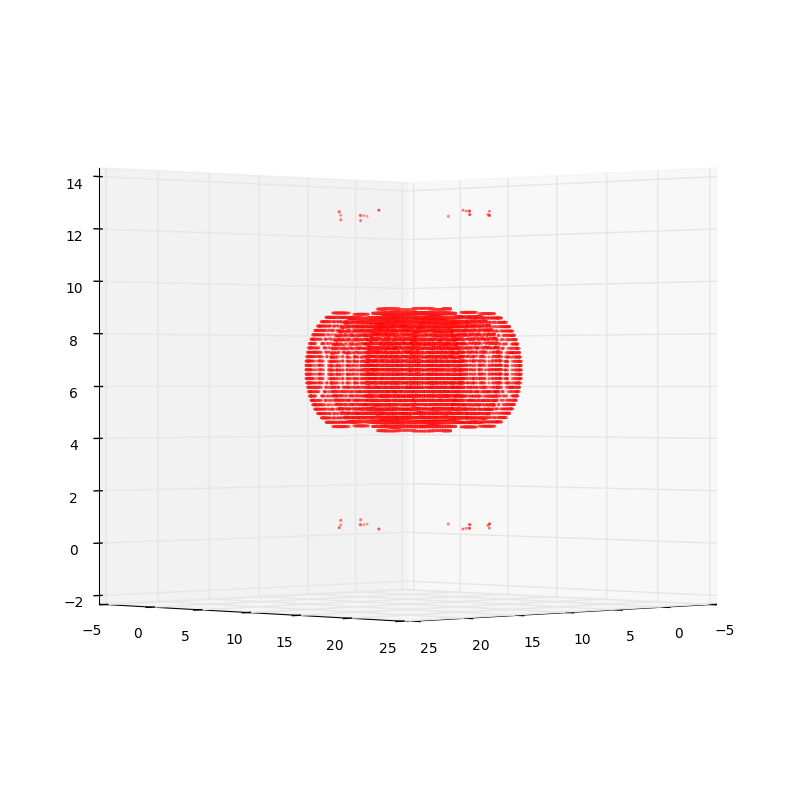

In [147]:
plot_cube(cube, 0.5, 0.6)

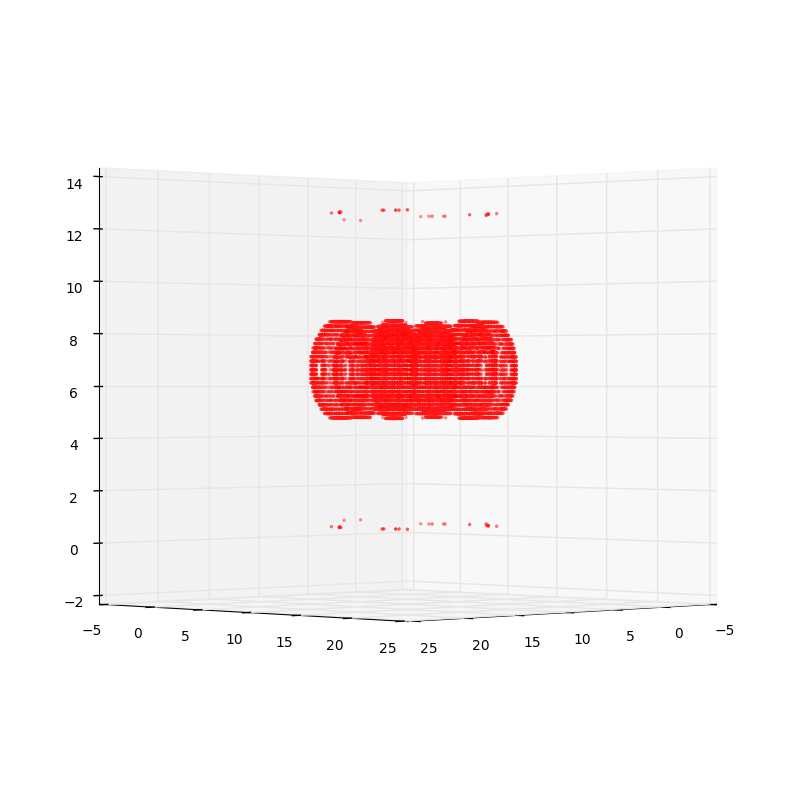

In [154]:
cube = Cube('/home/prace/Documents/projects/git_Clone/LOKT.02.048/c6h6.cube')
plot_cube(cube, 0.7, 0.8)

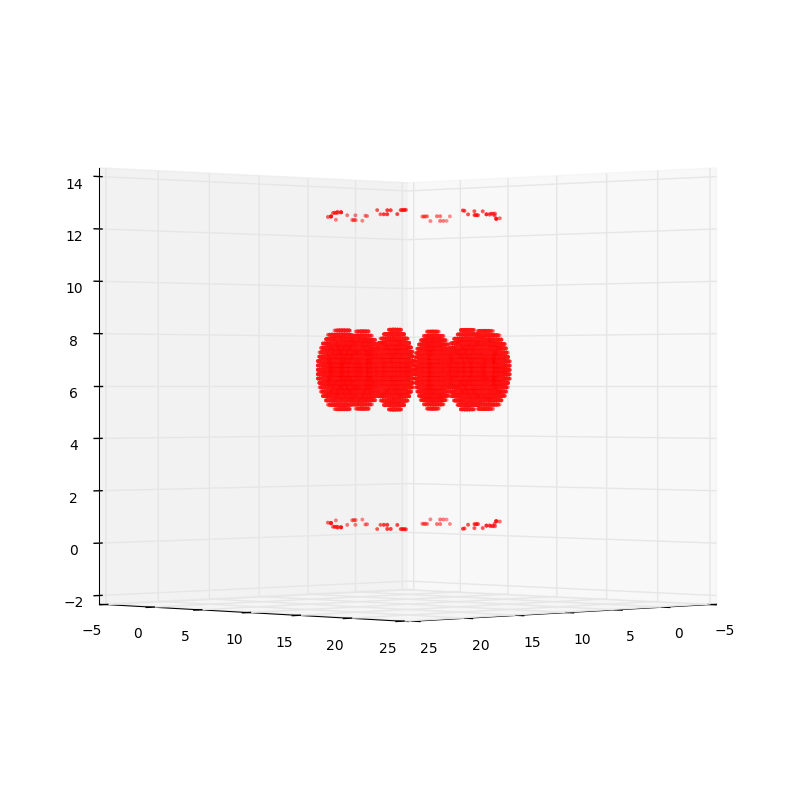

In [155]:
plot_cube(cube, 0.9, 1)

In [63]:
cmap = colormap(0.5)

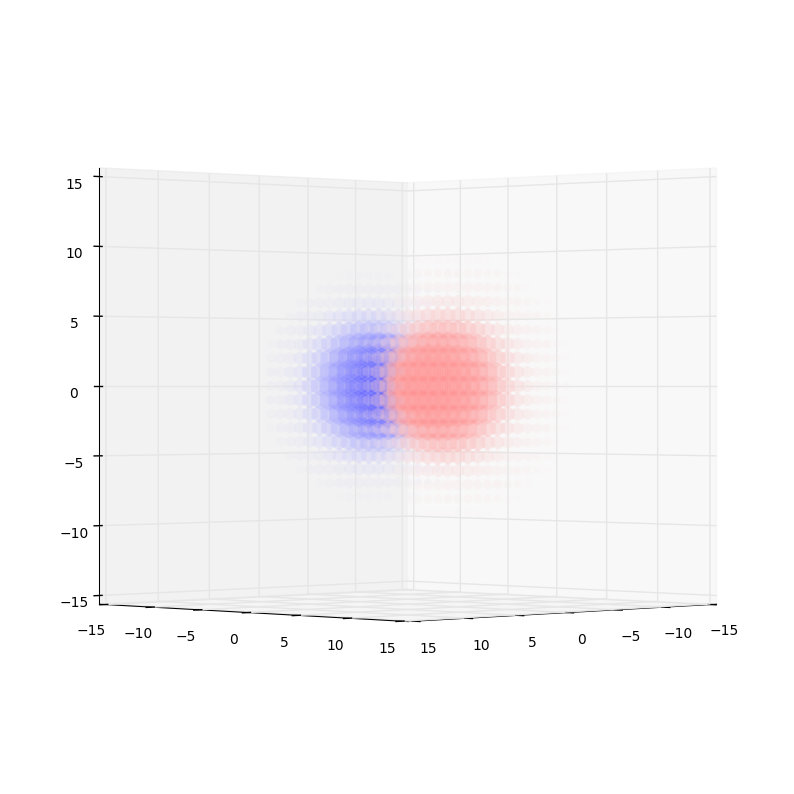

In [66]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

width = 10
resol = 21

a = np.linspace(-width,width,resol)
b = np.linspace(-width,width,resol)
c = np.linspace(-width,width,resol)

[Xr, Yr, Zr] = np.meshgrid(a, b, c)

C = eval(HWF_nlm(2,1,1,0,0,0))
S = np.abs(C)*10000

ax.scatter(Xr, Yr, Zr, c=C, s=S, cmap=cmap, marker='h', linewidths=0)

cmap =  colormap(.5)
ax.view_init(elev=0, azim=45)
plt.show()

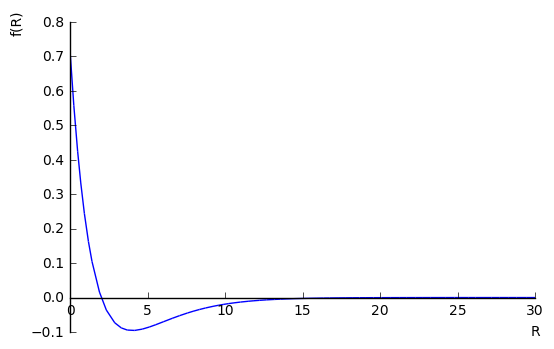

In [24]:
plot(R_nl(2,0,R), (R, 0, 30))

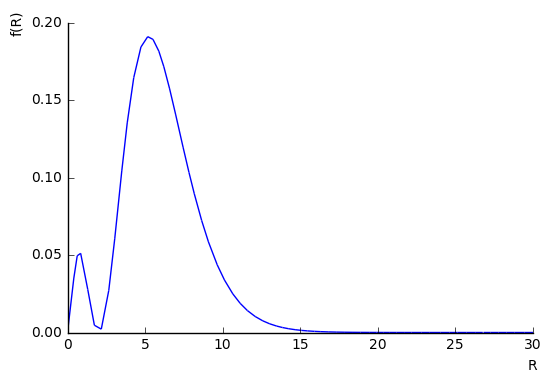

In [25]:
plot(R_nl(2,0,R)**2 * R**2, (R, 0, 30))

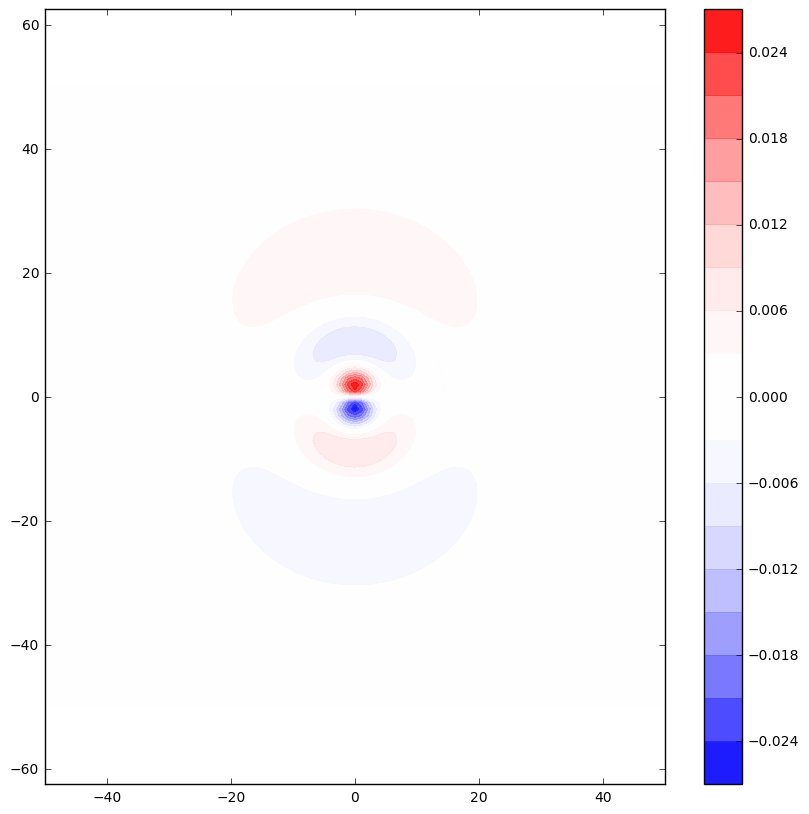

In [105]:
fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111, projection='3d')

width = 50
resol = 101

a = np.linspace(-width,width,resol)
b = np.linspace(-width,width,resol)

[Xr, Yr] = np.meshgrid(a, b)
Zr = 0

C = eval(HWF_nlm(4,1,1,0,0,0))
S = np.abs(C)*10000

cmap =  colormap(.5)

plt.axis('equal')
plt.contourf(X, Y, C, 20, cmap=cmap)
plt.colorbar()
plt.show()

0.332602351406
0.999875107142


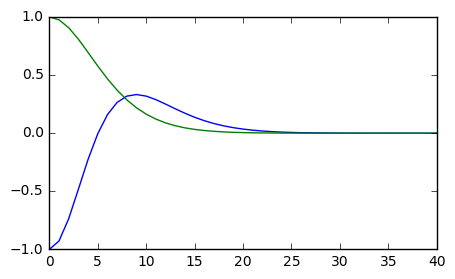

In [99]:
fig = plt.figure(figsize=(5,3))

width = 20
resol = 41

a = np.linspace(-width,width,resol)
b = np.linspace(-width,width,resol)
c = np.linspace(-width,width,resol)

[Xr, Yr, Zr] = np.meshgrid(a, b, c)

d = np.linspace(0,40,41)
Sp = []

for i in range(len(d)):
    I = -1*eval(HWF_nlm(2,1,0,0,0,0))*eval(HWF_nlm(2,1,0,0,0,d[i]))
    Sp.append(np.sum(I))
    
plt.plot(d,Sp)
print(np.max(Sp))
    
Pp = []

for i in range(len(d)):
    I = eval(HWF_nlm(2,1,-1,0,0,0))*eval(HWF_nlm(2,1,-1,0,0,d[i]))
    Pp.append(np.sum(I))
    
plt.plot(d,Pp)
print(np.max(Pp))

plt.show()

0.154633395197
0.559600849408


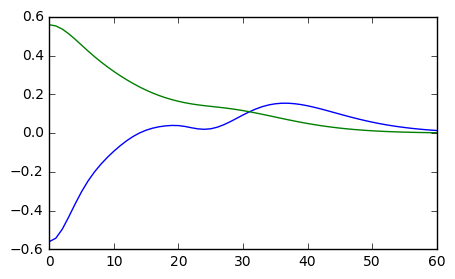

In [102]:
fig = plt.figure(figsize=(5,3))

width = 20
resol = 41

a = np.linspace(-width,width,resol)
b = np.linspace(-width,width,resol)
c = np.linspace(-width,width,resol)

[Xr, Yr, Zr] = np.meshgrid(a, b, c)

d = np.linspace(0,60,61)
Sp = []

for i in range(len(d)):
    I = -1*eval(HWF_nlm(4,1,0,0,0,0))*eval(HWF_nlm(4,1,0,0,0,d[i]))
    Sp.append(np.sum(I))
    
plt.plot(d,Sp)
print(np.max(Sp))
    
Pp = []

for i in range(len(d)):
    I = eval(HWF_nlm(4,1,-1,0,0,0))*eval(HWF_nlm(4,1,-1,0,0,d[i]))
    Pp.append(np.sum(I))
    
plt.plot(d,Pp)
print(np.max(Pp))

plt.show()

0.50466010688
9.78036140334e-18


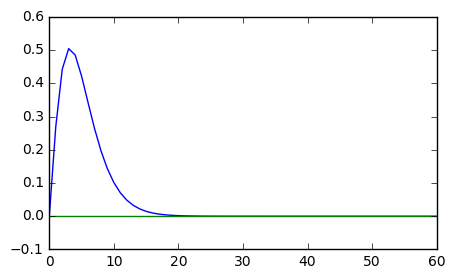

In [109]:
fig = plt.figure(figsize=(5,3))

width = 20
resol = 41

a = np.linspace(-width,width,resol)
b = np.linspace(-width,width,resol)
c = np.linspace(-width,width,resol)

[Xr, Yr, Zr] = np.meshgrid(a, b, c)

d = np.linspace(0,60,61)
spz = []

for i in range(len(d)):
    I = -1*eval(HWF_nlm(1,0,0,0,0,0))*eval(HWF_nlm(2,1,0,0,0,d[i]))
    spz.append(np.sum(I))
    
plt.plot(d,spz)
print(np.max(spz))

spy = []

for i in range(len(d)):
    I = -1*eval(HWF_nlm(1,0,0,0,0,0))*eval(HWF_nlm(2,1,-1,0,0,d[i]))
    spy.append(np.sum(I))
    
plt.plot(d,spy)
print(np.max(spy))

plt.show()